#Introduction

In this notebook, we explore the application of various topic modeling techniques on a collection of Medium articles sourced from Hugging Face. Topic modeling is a crucial task in natural language processing (NLP) that aims to discover the underlying themes or topics within a corpus of text documents. In this analysis, we employ three distinct methods for topic modeling: Latent Dirichlet Allocation (LDA), BERTopic, and Top2Vec.

**Latent Dirichlet Allocation (LDA)**: LDA is a widely used generative statistical model for discovering abstract topics within a collection of documents. It assumes that each document is a mixture of various topics, and each word in the document is attributable to one of the document's topics.

**BERTopic**: BERTopic is a topic modeling technique that leverages the contextual embeddings generated by pre-trained BERT models. By applying clustering algorithms to these embeddings, BERTopic identifies coherent clusters of documents, which represent distinct topics present in the corpus.

**Top2Vec**: Top2Vec is a novel approach to topic modeling that combines the advantages of document embeddings and clustering. It utilizes a document embedding technique similar to BERTopic, but instead of traditional clustering methods, it employs a novel algorithm to identify topics directly in the embedding space, enabling the discovery of both global and local topics.

##Importing the dataset from HuggingFace

The dataset 'BEE-spoke-data/medium-articles-en' from Hugging Face contains a collection of Medium articles in English, ready for analysis and exploration.








In [8]:
print('hello')

hello


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pip install datasets

In [ ]:
pip install pyldavis

In [7]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
from warnings import warn

if __name__ == '__main__':

  warn('Warning !', DeprecationWarning)

In [5]:
import pandas as pd
import plotly.express as px
import pyLDAvis.gensim_models
from datasets import load_dataset
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.phrases import Phrases, Phraser

import spacy
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

!python -m spacy download en_core_web_sm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
data = load_dataset('BEE-spoke-data/medium-articles-en')
data

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags', 'token_count'],
        num_rows: 171340
    })
    validation: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags', 'token_count'],
        num_rows: 4509
    })
    test: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags', 'token_count'],
        num_rows: 4509
    })
})

In [10]:
data = load_dataset('BEE-spoke-data/medium-articles-en', split='train')
data


Dataset({
    features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags', 'token_count'],
    num_rows: 171340
})

In [11]:
#Converting the dataset object into dataframe
df = pd.DataFrame(data)
df

title  \
0                       Create Barchart in Android Studio   
1       3 Mistakes Developers Make When They’re in a H...   
2                                         Hollywood To Go   
3                                  It’s a challenge guys!   
4       Global Startup News…Month In Review — February...   
...                                                   ...   
171335  How will smart cities look like 10 years from ...   
171336           Terraform And PagerDuty — Before You Try   
171337  Happy Birthday, Dad.. Too many times I’ve sat ...   
171338            40+ Ways to Make Extra Money This Month   
171339                        An Introvert’s Introduction   

                                                     text  \
0       I will keep the code simple and let's jump int...   
1       Not Reading Enough Code\n\nHave you ever seen ...   
2       Hollywood To Go\n\nCourtesy of Jeremy Moore/Fi...   
3       Damn, my people what do I say, it’s been more ...   
4       Friday, February 7, 2020\n\nGlobal Startup New...   
...                                                   ...   
171335  We all grew up having our imaginations run wil...   
171336  Terraform ideas\n\nTerraform And PagerDuty — B...   
171337  My Dad would’ve turned 64 today. He would’ve b...   
171338  Happy New Year everyone! Many people could use...   
171339  I’ve never liked to talk about myself. Wheneve...   

                                                      url  \
0       https://medium.com/@karthikganiga007/create-ba...   
1       https://medium.com/better-programming/3-mistak...   
2       https://medium.com/a-cornered-gurl/hollywood-t...   
3       https://medium.com/@magaratiprasuma20/its-a-ch...   
4       https://medium.com/@globalstartup/global-start...   
...                                                   ...   
171335  https://medium.com/startupx/how-will-smart-cit...   
171336  https://blog.devgenius.io/terraform-pagerduty-...   
171337  https://medium.com/@ctothep20/my-dad-wouldve-t...   
171338  https://medium.com/@mymoneychronicles/40-ways-...   
171339  https://medium.com/@4ar/an-introverts-introduc...   

                                      authors  \
0                           ['Kartik Ganiga']   
1                          ['Szymon Adamiak']   
2                         ['Tre L. Loadholt']   
3       ['Prasuma Magarati', 'With My Flaws']   
4                     ['Global Startup News']   
...                                       ...   
171335                          ['Raymond D']   
171336                  ['Kamil Świechowski']   
171337                     ['Courtney Peter']   
171338                       ['Jason Butler']   
171339                                     []   

                               timestamp  \
0       2019-06-21 08:04:00.165000+00:00   
1       2020-09-04 15:17:33.176000+00:00   
2       2017-04-23 21:50:07.985000+00:00   
3       2020-10-13 16:50:56.723000+00:00   
4       2020-02-07 15:39:27.080000+00:00   
...                                  ...   
171335  2020-09-02 08:20:48.092000+00:00   
171336  2020-07-21 08:33:31.047000+00:00   
171337  2020-09-15 17:54:50.681000+00:00   
171338  2019-02-14 15:49:01.665000+00:00   
171339  2020-12-26 07:43:14.948000+00:00   

                                                     tags  token_count  
0       ['UI', 'Android', 'Charts', 'Development', 'An...          707  
1       ['Programming', 'Education', 'Software Develop...          644  
2           ['Dreams', 'Audio Poems', 'Art', 'Hollywood']          277  
3       ['Life Lessons', 'Morning Routines', 'Happy', ...          492  
4       ['Startup', 'Investors', 'News', 'Venture Capi...          580  
...                                                   ...          ...  
171335  ['Sustainable Impact', 'Smart Cities', 'Future...         1424  
171336  ['Infrastructure As Code', 'Programming', 'Mon...         1124  
171337                               ['Birthday', 'Dads']         2318  
17133

In [12]:
# Create a histogram
fig = px.histogram(df, x='token_count', title='Histogram of Text Data')

# Show the plot
fig.show()


In [13]:

#Filtering the text less than 350 tokesn
df_new = df[df['token_count'] <= 350]
df_new

title  \
2                                     Hollywood To Go   
9                        Why I Stopped Writing Poetry   
14       How To Capture Your Complete Writing History   
17            This Is an Actual Video of Frank O’Hara   
33                        Anger is a Mystical Warning   
...                                               ...   
171313                                    To And From   
171321                                For What’s Real   
171322  8 Unheard Browser APIs You Should Be Aware Of   
171330                          Happiness is a Choice   
171339                    An Introvert’s Introduction   

                                                     text  \
2       Hollywood To Go\n\nCourtesy of Jeremy Moore/Fi...   
9       I stopped writing.\n\nStopped putting pen to p...   
14      Your writing history tells the personal story ...   
17      It was filmed the night before he died (he was...   
33      Something is Awry\n\nFamily Archives\n\nI’m wi...   
...                                                   ...   
171313  Slow down from your raging road\n\ndrunk on hi...   
171321  That old advice to “tend your garden” grows\n\...   
171322  8 Unheard Browser APIs You Should Be Aware Of\...   
171330  Too often, people ask me how are you always co...   
171339  I’ve never liked to talk about myself. Wheneve...   

                                                      url  \
2       https://medium.com/a-cornered-gurl/hollywood-t...   
9       https://medium.com/@claire-boyce24/i-stopped-w...   
14      https://medium.com/the-brave-writer/how-to-cap...   
17      https://medium.com/the-hairpin/this-is-an-actu...   
33      https://medium.com/the-neurons-of-heaven/anger...   
...                                                   ...   
171313  https://medium.com/storymaker/to-and-from-e85c...   
171321  https://medium.com/sonnetry/for-whats-real-138...   
171322  https://medium.com/better-programming/8-unhear...   
171330  https://medium.com/@mrinasugosh/happiness-is-a...   
171339  https://medium.com/@4ar/an-introverts-introduc...   

                     authors                         timestamp  \
2        ['Tre L. Loadholt']  2017-04-23 21:50:07.985000+00:00   
9           ['Claire Boyce']  2020-12-23 21:21:24.468000+00:00   
14       ['Barry Desautels']  2020-05-22 02:50:25.799000+00:00   
17         ['Nicole Cliffe']  2016-06-02 01:47:38.376000+00:00   
33           ['Tim Shapiro']  2020-12-20 18:11:06.084000+00:00   
...                      ...                               ...   
171313        ['J.D. Harms']  2020-12-21 16:21:38.361000+00:00   
171321      ['Jane Woodman']  2020-05-07 00:14:25.787000+00:00   
171322      ['Mahdhi Rezvi']  2020-08-04 16:05:37.181000+00:00   
171330  ['Mrinalini Sugosh']  2020-02-15 23:37:12.866000+00:00   
171339                    []  2020-12-26 07:43:14.948000+00:00   

                                                     tags  token_count  
2           ['Dreams', 'Audio Poems', 'Art', 'Hollywood']          277  
9       ['Poetry', 'Poet', 'Poems On Medium', 'Poem', ...          161  
14      ['Writing Prompts', 'Writer', 'Writing', 'Writ...          212  
17                                   ['Genius', 'Poetry']          103  
33      ['Neuroscience', 'Religion', 'Family', 'God', ...          342  
...                                                   ...          ...  
171313  ['Musing', 'Relationships', 'Fragments', 'Imag...          214  
171321  ['Compost', 'Poetry', 'Garden', 'Sonnet', 'Rea...          132  
171322  ['Technology', 'Software Development', 'JavaSc...          175  
171330  ['Happiness In Life', 'Love Yourself', 'Happin...          244  
171339  ['Mental Health', 'Thoughts', 'Introduction', ...          298  

[26404 rows x 7 columns]

##Preprocessing

In [14]:
text_data = df_new['text']
text_data

2         Hollywood To Go\n\nCourtesy of Jeremy Moore/Fi...
9         I stopped writing.\n\nStopped putting pen to p...
14        Your writing history tells the personal story ...
17        It was filmed the night before he died (he was...
33        Something is Awry\n\nFamily Archives\n\nI’m wi...
                                ...                        
171313    Slow down from your raging road\n\ndrunk on hi...
171321    That old advice to “tend your garden” grows\n\...
171322    8 Unheard Browser APIs You Should Be Aware Of\...
171330    Too often, people ask me how are you always co...
171339    I’ve never liked to talk about myself. Wheneve...
Name: text, Length: 26404, dtype: object

In [54]:
# Lowercase the text
text_data_lower = text_data.str.lower()

In [55]:
# Remove punctuations
text_data_no_punct = text_data_lower.str.replace(r'[^\w\s]', '', regex=True)


In [56]:
# Remove HTML syntaxes
text_data_no_html = text_data_no_punct.str.replace(r'<.*?>', '', regex=True)


In [57]:
# Remove URLs
text_data_no_url = text_data_no_html.str.replace(r'https?://\S+|www\.\S+', '', regex=True)


In [58]:
# Replace newline characters with space
text_data_no_newline = text_data_no_url.str.replace(r'\n', ' ', regex=True)


In [59]:
# Strip extra spaces
text_data_stripped = text_data_no_newline.str.strip()


In [60]:
# Tokenize the text
text_data_tokenized = text_data_stripped.apply(word_tokenize)

In [61]:
# Convert STOPWORDS to a set for faster lookup
gensim_stopwords = set(STOPWORDS)

# Remove stopwords from tokenized text
text_data_no_stopwords = text_data_tokenized.apply(lambda tokens: [word for word in tokens if word.lower() not in gensim_stopwords])

In [62]:
# Remove numbers from the text using regex
text_data_no_numbers = text_data_no_stopwords.apply(lambda tokens: [word for word in tokens if not re.match(r'\d+', word)])
text_data_no_numbers

2         [hollywood, courtesy, jeremy, moorefine, art, ...
9         [stopped, writing, stopped, putting, pen, pape...
14        [writing, history, tells, personal, story, ove...
17        [filmed, night, died, run, dune, buggy, island...
33        [awry, family, archives, im, married, couple, ...
                                ...                        
171313    [slow, raging, road, drunk, highway, fumes, ga...
171321    [old, advice, tend, garden, grows, true, passi...
171322    [unheard, browser, apis, aware, experimental, ...
171330    [people, ask, constantly, happy, selfreflectio...
171339    [ive, liked, talk, asks, mini, identity, crisi...
Name: text, Length: 26404, dtype: object

In [63]:
text_list=text_data_no_numbers.tolist()


In [64]:
def lemmatize_text(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    """
    Lemmatize the input texts using spaCy.

    Parameters:
    -----------
    texts : list of str
        List of texts to be lemmatized.
    allowed_postags : list of str, optional
        List of allowed POS tags for lemmatization. Defaults to ["NOUN", "ADJ", "VERB", "ADV"].

    Returns:
    --------
    list of list of str
        List of lemmatized texts, where each text is represented as a list of lemmatized tokens.

    Example:
    --------
    # Apply lemmatization to text_data_no_stopwords
    lemmatized_texts = lemmatize_text(text_list)
    """
    # Load the spaCy English model with specific components disabled
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

    # List to store lemmatized texts
    texts_out = []

    # Iterate over each text in the input list
    for text in texts:
        # Process the text using spaCy
        doc = nlp(' '.join(text))

        # List to store lemmatized tokens
        lemmatized_tokens = []

        # Iterate over each token in the processed document
        for token in doc:
            # Check if the token's POS tag is in the list of allowed POS tags
            if token.pos_ in allowed_postags:
                # Append the lemma of the token to the list of lemmatized tokens
                lemmatized_tokens.append(token.lemma_)

        # Append the list of lemmatized tokens to the list of lemmatized texts
        texts_out.append(lemmatized_tokens)

    return texts_out


lemmatized_texts = lemmatize_text(text_list)



In [ ]:
lemmatized_texts[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[['musical',
  'selection',
  's',
  'get',
  'dream',
  'tell',
  'sister',
  's',
  'go',
  'hand',
  'flail',
  'air',
  'outta',
  'control',
  's',
  'bone',
  'remotely',
  'close',
  'talent',
  's',
  'get',
  'dream',
  'trample',
  'schoolboy',
  'fever',
  'spend',
  'free',
  'time',
  'create',
  'art',
  'buy',
  's',
  'go',
  'hollywood',
  'city',
  'light',
  'overprice',
  'ecstasy',
  'hold',
  'somethin',
  'word',
  'louder',
  'bullhorn',
  'muster',
  'sean',
  's',
  'get',
  'brand',
  'new',
  'car',
  'ride',
  'flex',
  'show',
  'candyred',
  'paint',
  've',
  'get',
  'dream',
  'important',
  's',
  'go',
  'escape',
  'death',
  'grip',
  'bill',
  'stale',
  'coffee',
  'beat',
  'trash',
  'bin',
  'hold',
  'dayoldbread',
  'mold',
  'consider',
  'dangerous',
  'consumption',
  'eat',
  'course',
  'hollywood',
  'year',
  'road',
  'glass',
  'globe',
  'figurine',
  'stand',
  'wait',
  'shake',
  'chance'],
 ['stop',
  'write',
  'stop',
  'put'

##LDA - Latent Dirichlet Allocation

In [67]:
dictionary = Dictionary(lemmatized_texts)

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in lemmatized_texts]


In [ ]:
# Train the LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=15,
                     passes=20,
                     update_every = 1,
                     chunksize=500,
                     alpha = 'auto')

# Print the topics and their top words
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0: 0.035*"medium" + 0.029*"money" + 0.027*"video" + 0.027*"article" + 0.025*"read" + 0.023*"post" + 0.022*"content" + 0.020*"write" + 0.018*"writer" + 0.018*"marketing"
Topic 1: 0.028*"health" + 0.025*"body" + 0.020*"energy" + 0.018*"weight" + 0.018*"help" + 0.015*"habit" + 0.015*"trading" + 0.013*"mental" + 0.013*"loss" + 0.013*"exercise"
Topic 2: 0.037*"food" + 0.031*"baby" + 0.024*"water" + 0.023*"market" + 0.018*"clean" + 0.016*"hair" + 0.014*"skin" + 0.013*"eat" + 0.013*"expect" + 0.013*"plant"
Topic 3: 0.014*"people" + 0.010*"change" + 0.009*"world" + 0.008*"human" + 0.008*"country" + 0.007*"woman" + 0.007*"state" + 0.007*"issue" + 0.007*"high" + 0.006*"case"
Topic 4: 0.022*"work" + 0.016*"company" + 0.016*"help" + 0.015*"business" + 0.014*"new" + 0.012*"team" + 0.010*"experience" + 0.009*"build" + 0.009*"learn" + 0.009*"technology"
Topic 5: 0.018*"heart" + 0.016*"light" + 0.016*"love" + 0.016*"eye" + 0.012*"night" + 0.012*"hand" + 0.010*"hold" + 0.010*"fall" + 0.009*"leave

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12     0.013956 -0.273612       1        1  21.397988
8      0.118289 -0.191374       2        1  12.636597
4     -0.107763 -0.018199       3        1  12.407742
3     -0.005233 -0.067207       4        1  11.869816
5      0.255037 -0.219538       5        1   7.001715
6     -0.170172  0.053011       6        1   6.183690
0     -0.078559  0.079286       7        1   5.001356
10    -0.169739 -0.033655       8        1   4.532105
11    -0.238913 -0.021709       9        1   4.531209
9     -0.192632  0.013413      10        1   3.414373
1      0.081074  0.094942      11        1   2.959616
13     0.022179  0.100832      12        1   2.570808
7      0.204707  0.181121      13        1   2.011715
2      0.115388  0.164006      14        1   1.862027
14     0.152382  0.138684      15        1   1.619243, topic_info=            Term          Freq         Total Category  logprob  loglift
124         know  10533.000000  10533.000000  Default  30.0000  30.0000
813       design   4005.000000   4005.000000  Default  29.0000  29.0000
163          day   9180.000000   9180.000000  Default  28.0000  28.0000
67          year   9783.000000   9783.000000  Default  27.0000  27.0000
1293       datum   5142.000000   5142.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
130         look    376.449898   7228.286307  Topic15  -4.4288   1.1682
1860      modern    227.992945    632.140886  Topic15  -4.9303   3.1034
880        image    283.703370   2922.663748  Topic15  -4.7116   1.7909
741   background    222.126995    612.760351  Topic15  -4.9563   3.1085
221       office    211.207964    717.160022  Topic15  -5.0067   2.9008

[880 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2250      8  0.991727  abstract
534       3  0.001523    accord
534       4  0.705290    accord
534       8  0.022088    accord
534      12  0.130242    accord
...     ...       ...       ...
67       13  0.030256      year
182       2  0.827665     young
182       4  0.171644     young
1144      7  0.998018   youtube
2878     11  0.997538      zone

[1725 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 9, 5, 4, 6, 7, 1, 11, 12, 10, 2, 14, 8, 3, 15])

###Topic Visualization

Each bubble represents a topic. The larger the bubble, the higher percentage of that text in the corpus is about that topic.

Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.

Red bars give the estimated number of times a given term was generated by a given topic.

The further the bubbles are away from each other, the more different they are.

In [ ]:
perplexity = lda_model.log_perplexity(corpus, total_docs=25000)
perplexity


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



-9.311541128067583

In [ ]:
# Evaluate the model using coherence score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Coherence Score: 0.5213372961696202


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit = 24, start=8, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
       #model =LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     passes=20,
                     update_every = 1,
                     chunksize=500,
                     alpha = 'auto',
                      eta = 'auto'
                         )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=lemmatized_texts, start=4, limit=30, step=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



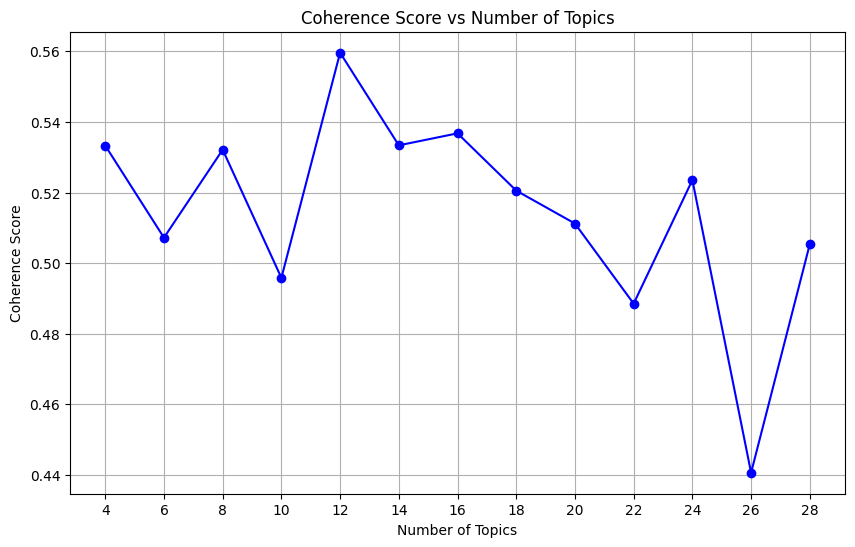

In [ ]:
import matplotlib.pyplot as plt

def plot_coherence_values(coherence_values, start, limit, step):
    """
    Plot coherence values for different number of topics.

    Parameters:
    coherence_values : list
        List of coherence values.
    start : int
        Starting number of topics.
    limit : int
        Maximum number of topics.
    step : int
        Step size between number of topics.
    """
    # Generate x-axis values (number of topics)
    topics = range(start, limit, step)

    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(topics, coherence_values, marker='o', color='b', linestyle='-')
    plt.title('Coherence Score vs Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(topics)
    plt.grid(True)
    plt.show()

# Usage
plot_coherence_values(coherence_values, start=4, limit=30, step=2)


In [ ]:
# Print coherence scores
print("Number of Topics - Coherence Score")
for num_topics, score in zip(range(4, 30, 2), coherence_values):
    print(f"{num_topics} - {score}")

Number of Topics - Coherence Score
4 - 0.5332941077085295
6 - 0.5072064260728593
8 - 0.5321311970006641
10 - 0.49582776893806385
12 - 0.55960596337905
14 - 0.5333670009250144
16 - 0.5367673583219792
18 - 0.5205415461096417
20 - 0.5112123136602267
22 - 0.4885169552431359
24 - 0.5235363539880269
26 - 0.4406208913105812
28 - 0.5053693590839521


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



###Trying out different parameters

**Hyperparameter Tuning**

Model hyperparameters can be thought of as settings for a machine learning algorithm that are tuned by the data scientist before training. Examples would be the number of trees in the random forest, or in our case, number of topics K

Model parameters can be thought of as what the model learns during training, such as the weights for each word in a given topic

Now that we have the baseline coherence score for the default LDA model, let’s perform a series of sensitivity tests to help determine the following model hyperparameters:

Number of Topics (K)
Dirichlet hyperparameter alpha: Document-Topic Density
Dirichlet hyperparameter beta: Word-Topic Density

###Train the LDA model with topic number 15 , alpha 0.1, eta 0.3

In [69]:
# Train the LDA model with topic number 15 , alpha 0.1, eta 0.3
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=15,
                     passes=20,
                     update_every = 1,
                     chunksize=500,
                     alpha = 0.1,
                     eta = 0.3)

# Print the topics and their top words
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}")

# Evaluate the model using coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')

Topic 0: 0.036*"write" + 0.025*"read" + 0.024*"story" + 0.019*"book" + 0.018*"article" + 0.016*"learn" + 0.014*"writer" + 0.012*"student" + 0.011*"medium" + 0.011*"new"
Topic 1: 0.018*"time" + 0.015*"people" + 0.014*"know" + 0.013*"thing" + 0.013*"want" + 0.012*"life" + 0.012*"think" + 0.011*"day" + 0.010*"s" + 0.010*"feel"
Topic 2: 0.036*"datum" + 0.015*"function" + 0.013*"value" + 0.012*"object" + 0.011*"model" + 0.011*"use" + 0.009*"class" + 0.009*"example" + 0.009*"number" + 0.009*"method"
Topic 3: 0.010*"health" + 0.008*"increase" + 0.008*"change" + 0.007*"report" + 0.007*"human" + 0.006*"people" + 0.006*"high" + 0.006*"pandemic" + 0.006*"covid19" + 0.005*"cause"
Topic 4: 0.012*"token" + 0.011*"exchange" + 0.011*"blockchain" + 0.011*"market" + 0.009*"wallet" + 0.009*"user" + 0.009*"asset" + 0.009*"bitcoin" + 0.008*"price" + 0.008*"transaction"
Topic 5: 0.011*"love" + 0.007*"heart" + 0.007*"day" + 0.007*"eye" + 0.007*"know" + 0.006*"feel" + 0.006*"time" + 0.006*"night" + 0.006*"lea

In [70]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary)
vis

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.031961 -0.091838       1        1  22.968779
5     -0.168802 -0.023093       2        1  12.499423
14     0.164549 -0.037541       3        1  11.170277
8      0.187731  0.066448       4        1   8.634690
0      0.106598 -0.040416       5        1   5.869585
2      0.142357  0.110854       6        1   5.801563
3      0.021581 -0.063774       7        1   5.746627
4      0.120451 -0.093979       8        1   5.011876
13    -0.051987 -0.193756       9        1   4.390991
9     -0.107315  0.082383      10        1   3.930418
11     0.141232  0.024311      11        1   3.846716
12    -0.283773 -0.147693      12        1   2.896866
7     -0.064060 -0.029711      13        1   2.841974
10    -0.035259  0.207928      14        1   2.656019
6     -0.205263  0.229877      15        1   1.734195, topic_info=          Term         Freq        Total Category  logprob  loglift
104      write  5670.000000  5670.000000  Default  30.0000  30.0000
1293     datum  4879.000000  4879.000000  Default  29.0000  29.0000
813     design  3376.000000  3376.000000  Default  28.0000  28.0000
108   business  3760.000000  3760.000000  Default  27.0000  27.0000
67        year  8584.000000  8584.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
524      sweet   200.151748   500.280755  Topic15  -5.1291   3.1385
6960       cup   157.373530   291.662012  Topic15  -5.3695   3.4377
738        add   224.828951  3044.853439  Topic15  -5.0128   1.4488
532      water   184.951715  1184.662149  Topic15  -5.2081   2.1975
2159      lose   148.033143  1872.284527  Topic15  -5.4307   1.5171

[976 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2250      6  0.962550  abstract
2250     14  0.006779  abstract
6536      7  0.197316     abuse
6536     12  0.789264     abuse
3443      5  0.955330  academic
...     ...       ...       ...
182       9  0.052076     young
182      12  0.601998     young
6175     12  0.982041     youth
1144     11  0.708899   youtube
1144     13  0.282676   youtube

[2505 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 15, 9, 1, 3, 4, 5, 14, 10, 12, 13, 8, 11, 7])

### Train the LDA model with topic num 15 , alpha 0.6 , eta 0.3

In [71]:
# Train the LDA model with topic num 15 , alpha 0.6 , eta 0.3
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=15,
                     passes=20,
                     update_every = 1,
                     chunksize=500,
                     alpha = 0.6,
                     eta = 0.3)

# Print the topics and their top words
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}")

# Evaluate the model using coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')

Topic 0: 0.024*"money" + 0.013*"market" + 0.012*"token" + 0.011*"price" + 0.011*"exchange" + 0.011*"blockchain" + 0.010*"asset" + 0.009*"wallet" + 0.009*"financial" + 0.009*"cash"
Topic 1: 0.017*"change" + 0.015*"life" + 0.014*"human" + 0.014*"world" + 0.011*"understand" + 0.011*"way" + 0.009*"problem" + 0.008*"create" + 0.008*"mean" + 0.008*"relationship"
Topic 2: 0.016*"work" + 0.016*"company" + 0.014*"team" + 0.012*"technology" + 0.012*"business" + 0.011*"help" + 0.010*"development" + 0.010*"project" + 0.009*"industry" + 0.009*"new"
Topic 3: 0.046*"datum" + 0.017*"number" + 0.016*"model" + 0.012*"image" + 0.011*"use" + 0.010*"machine" + 0.009*"example" + 0.009*"problem" + 0.009*"learn" + 0.009*"map"
Topic 4: 0.026*"new" + 0.024*"user" + 0.019*"app" + 0.016*"send" + 0.015*"event" + 0.013*"update" + 0.013*"feature" + 0.012*"community" + 0.011*"week" + 0.011*"support"
Topic 5: 0.040*"year" + 0.024*"play" + 0.021*"woman" + 0.021*"game" + 0.016*"watch" + 0.014*"live" + 0.014*"music" + 0.

In [72]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary)
vis

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.158319 -0.127867       1        1  13.462744
10    -0.276958  0.020047       2        1   9.639825
2      0.187565  0.071931       3        1   8.448619
6      0.148010 -0.163848       4        1   8.230273
1     -0.000377 -0.010192       5        1   7.097526
14    -0.040684  0.208648       6        1   6.399558
7     -0.262885 -0.108102       7        1   5.974579
4      0.107168 -0.049944       8        1   5.752726
9      0.017970 -0.197251       9        1   5.579233
11     0.157350 -0.052884      10        1   5.513240
3      0.143315 -0.056238      11        1   5.444445
0      0.134374  0.150640      12        1   5.075708
13    -0.008170  0.063003      13        1   4.657469
5     -0.068357  0.158859      14        1   4.547514
12    -0.080003  0.093198      15        1   4.176540, topic_info=       Term         Freq        Total Category  logprob  loglift
104   write  5717.000000  5717.000000  Default  30.0000  30.0000
67     year  8464.000000  8464.000000  Default  29.0000  29.0000
1293  datum  4935.000000  4935.000000  Default  28.0000  28.0000
174    read  4855.000000  4855.000000  Default  27.0000  27.0000
148   story  3907.000000  3907.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
449    good   522.137551  7797.432261  Topic15  -5.0492   0.4721
738     add   364.041476  3062.100526  Topic15  -5.4098   1.0461
158     use   397.730576  6314.411657  Topic15  -5.3213   0.4109
266    help   396.583913  6365.449409  Topic15  -5.3242   0.3999
404   clean   301.184093   944.505877  Topic15  -5.5994   2.0327

[941 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2042      3  0.289111     ability
2042      5  0.638968     ability
2042      8  0.067497     ability
6536      6  0.984941       abuse
4613      3  0.965396  accelerate
...     ...       ...         ...
67        6  0.108923        year
67       12  0.009451        year
67       13  0.002953        year
67       14  0.421399        year
1144     10  0.991750     youtube

[2201 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 11, 3, 7, 2, 15, 8, 5, 10, 12, 4, 1, 14, 6, 13])

### Train the LDA model with topic num 15 , eta 0.3

In [ ]:
# Train the LDA model with topic num 15 , eta 0.3
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=15,
                     passes=20,
                     update_every = 1,
                     chunksize=500,
                     alpha = 'auto',
                     eta = 0.3)

# Print the topics and their top words
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0: 0.013*"country" + 0.012*"people" + 0.008*"say" + 0.008*"state" + 0.008*"black" + 0.008*"pandemic" + 0.007*"law" + 0.007*"government" + 0.007*"covid19" + 0.006*"public"
Topic 1: 0.016*"company" + 0.015*"technology" + 0.014*"market" + 0.011*"year" + 0.010*"industry" + 0.009*"increase" + 0.008*"global" + 0.008*"new" + 0.007*"report" + 0.006*"growth"
Topic 2: 0.011*"light" + 0.008*"eye" + 0.007*"night" + 0.007*"tree" + 0.006*"hand" + 0.006*"water" + 0.006*"leave" + 0.005*"photo" + 0.005*"sky" + 0.005*"hair"
Topic 3: 0.016*"people" + 0.015*"work" + 0.014*"learn" + 0.011*"help" + 0.011*"way" + 0.010*"need" + 0.009*"change" + 0.008*"time" + 0.008*"good" + 0.008*"life"
Topic 4: 0.020*"music" + 0.015*"device" + 0.012*"camera" + 0.011*"phone" + 0.011*"apple" + 0.009*"video" + 0.008*"tv" + 0.008*"home" + 0.008*"artist" + 0.007*"good"
Topic 5: 0.026*"color" + 0.023*"food" + 0.014*"coffee" + 0.010*"eat" + 0.010*"clean" + 0.010*"meal" + 0.009*"water" + 0.009*"art" + 0.009*"oil" + 0.008*"use

In [ ]:
# Evaluate the model using coherence score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Coherence Score: 0.5730922623833107


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.179764 -0.205289       1        1  18.915578
3     -0.005875 -0.175159       2        1  16.445234
13     0.150947 -0.125091       3        1   8.413185
2     -0.261710  0.049740       4        1   7.560613
8     -0.281810 -0.088107       5        1   6.843341
10     0.197459 -0.019741       6        1   6.378440
12     0.095799 -0.058572       7        1   5.749659
1      0.144357  0.115797       8        1   4.769922
11     0.120948 -0.044596       9        1   4.700850
0     -0.034203  0.088003      10        1   4.671307
6      0.044153 -0.084785      11        1   4.510389
14     0.134155  0.044956      12        1   3.832764
7     -0.046849  0.207963      13        1   2.797821
4      0.026607  0.065126      14        1   2.513779
5     -0.104212  0.229754      15        1   1.897119, topic_info=          Term         Freq        Total Category  logprob  loglift
104      write  5570.000000  5570.000000  Default  30.0000  30.0000
125       life  7407.000000  7407.000000  Default  29.0000  29.0000
1293     datum  4778.000000  4778.000000  Default  28.0000  28.0000
388       love  5406.000000  5406.000000  Default  27.0000  27.0000
223     people  9207.000000  9207.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
158        use   283.226277  6171.846499  Topic15  -4.8717   0.8833
385       home   206.038701  2715.984090  Topic15  -5.1899   1.3860
1759  material   161.880582   560.723662  Topic15  -5.4311   2.7225
1170     small   174.947803  2109.547689  Topic15  -5.3535   1.4751
1038     table   151.559728   916.553571  Topic15  -5.4970   2.1652

[969 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2042      2  0.858426  ability
2042      3  0.086943  ability
2042      6  0.006603  ability
2042      8  0.044022  ability
2042     12  0.001101  ability
...     ...       ...      ...
182      11  0.027805    young
182      13  0.339836    young
1144      9  0.135341  youtube
1144     11  0.776548  youtube
1144     14  0.079874  youtube

[2333 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 14, 3, 9, 11, 13, 2, 12, 1, 7, 15, 8, 5, 6])

### Train the LDA model with topic 15 and eta 0.7

In [ ]:
# Train the LDA model with topic 15 and eta 0.7
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=15,
                     passes=20,
                     update_every = 1,
                     chunksize=500,
                     alpha = 'auto',
                     eta = 0.7)

# Print the topics and their top words
for topic_id, topic_words in lda_model.print_topics():
    print(f"Topic {topic_id}: {topic_words}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0: 0.043*"write" + 0.029*"read" + 0.029*"medium" + 0.026*"story" + 0.022*"book" + 0.021*"post" + 0.021*"article" + 0.019*"writer" + 0.013*"content" + 0.011*"blog"
Topic 1: 0.018*"food" + 0.014*"body" + 0.013*"weight" + 0.010*"water" + 0.009*"eat" + 0.008*"hair" + 0.008*"skin" + 0.007*"cell" + 0.007*"oil" + 0.007*"healthy"
Topic 2: 0.057*"datum" + 0.017*"model" + 0.013*"machine" + 0.011*"image" + 0.009*"learn" + 0.008*"map" + 0.008*"data" + 0.008*"chart" + 0.006*"use" + 0.006*"analysis"
Topic 3: 0.010*"love" + 0.008*"heart" + 0.007*"eye" + 0.006*"light" + 0.006*"leave" + 0.006*"feel" + 0.005*"life" + 0.005*"day" + 0.005*"night" + 0.005*"hand"
Topic 4: 0.013*"use" + 0.013*"user" + 0.013*"app" + 0.013*"create" + 0.011*"file" + 0.011*"code" + 0.010*"application" + 0.009*"need" + 0.008*"run" + 0.008*"add"
Topic 5: 0.026*"function" + 0.018*"object" + 0.016*"class" + 0.016*"value" + 0.011*"use" + 0.011*"method" + 0.010*"example" + 0.010*"number" + 0.010*"return" + 0.009*"code"
Topic 6: 

In [ ]:
# Evaluate the model using coherence score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Coherence Score: 0.5718591618946748


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.026093 -0.256707       1        1  29.346219
3      0.204226 -0.207002       2        1  10.886236
14    -0.152452 -0.003092       3        1  10.311877
4     -0.194517 -0.047762       4        1   9.105066
9     -0.148993  0.073372       5        1   6.608711
7      0.024369 -0.005897       6        1   6.139640
10    -0.122107  0.054762       7        1   5.007116
0     -0.044649  0.038380       8        1   4.073547
11     0.138735  0.007068       9        1   3.479329
5     -0.088173 -0.050166      10        1   3.343201
2     -0.081022  0.040385      11        1   3.226431
1      0.131945  0.064568      12        1   2.254125
13     0.060145  0.095157      13        1   2.167886
8      0.098203  0.103207      14        1   2.154900
6      0.200382  0.093728      15        1   1.895717, topic_info=         Term         Freq        Total Category  logprob  loglift
104     write  5356.000000  5356.000000  Default  30.0000  30.0000
1293    datum  4298.000000  4298.000000  Default  29.0000  29.0000
148     story  3659.000000  3659.000000  Default  28.0000  28.0000
174      read  4555.000000  4555.000000  Default  27.0000  27.0000
223    people  8993.000000  8993.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
204    family   398.096034  1691.110875  Topic15  -4.5305   2.5191
713    mental   237.715136   589.614936  Topic15  -5.0461   3.0572
614      care   322.324089  1678.752863  Topic15  -4.7417   2.3153
682       mom   171.515963   288.278423  Topic15  -5.3725   3.4463
4648  teacher   178.305720   393.816165  Topic15  -5.3337   3.1732

[972 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7313      1  0.011485  abortion
7313      2  0.011485  abortion
7313      3  0.011485  abortion
7313      4  0.011485  abortion
7313      5  0.011485  abortion
...     ...       ...       ...
1144     11  0.002608   youtube
1144     12  0.002608   youtube
1144     13  0.002608   youtube
1144     14  0.787764   youtube
1144     15  0.002608   youtube

[12810 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 4, 15, 5, 10, 8, 11, 1, 12, 6, 3, 2, 14, 9, 7])

###LDA Observation


Using LDA with an automatic alpha setting, 15 topics, and an eta value of 0.3 yielded a favorable coherence score of 0.573. This indicates that the model was able to effectively capture the underlying structure and coherence within the dataset, suggesting promising results for topic modeling.

##BERTopic

BERTopic generates document embedding with pre-trained transformer-based language models, clusters these embeddings, and finally, generates topic representations with the class-based TF-IDF procedure.

Three main algorithm components
**Embed Documents**: Extract document embeddings with Sentence Transformers. Since the data we are working with are article titles, we will need to obtain sentence embeddings, which BERTopic lets us choose conveniently, from among many sentence transformer model.

**Cluster Documents**: Create groups of similar documents with UMAP (to reduce the dimensionality of embeddings) and HDBSCAN (to identify and cluster semantically similar documents)

**Create Topic Representation**: Extract and reduce topics with c-TF-IDF (class-based term frequency, inverse document frequency).

TF-IDF allows for comparing the importance of words between documents by computing the frequency of a word in a given document and also the measure of how prevalent the word is in the entire corpus.

Now, if we instead treat all documents in a single cluster as a single document and then perform TF-IDF, the result would be importance scores for words within a cluster. The more important words are within a cluster, the more representative they are of that topic. Therefore, we can obtain keyword-based descriptions for each topic! This is super powerful when it comes to inferring meaning from the groupings yielded by any unsupervised clustering technique.



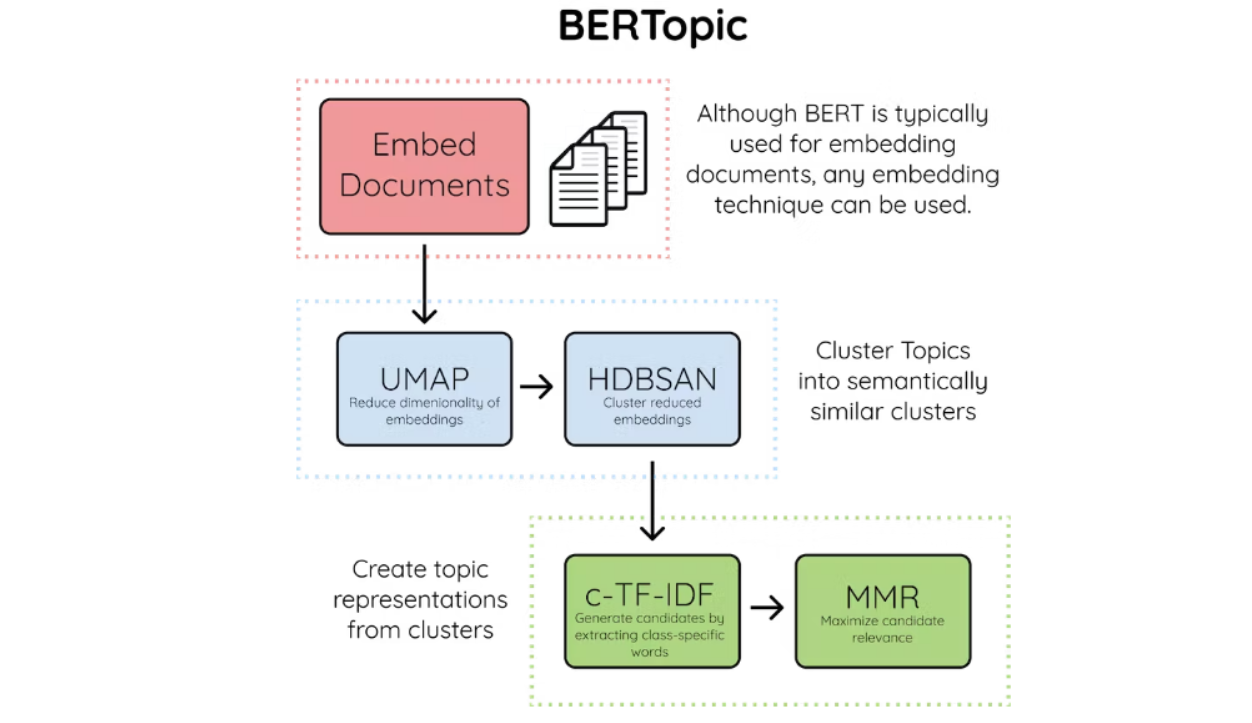

In [ ]:
pip install bertopic

In [ ]:
from bertopic import BERTopic

###Training with 50 topics

In [ ]:
topic_model = BERTopic(verbose=True ,
                       min_topic_size = 50,
                       calculate_probabilities = True)

In [ ]:
topics, probs = topic_model.fit_transform(df_new['text'])

2024-04-16 04:42:41,957 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/826 [00:00<?, ?it/s]

2024-04-16 05:56:56,415 - BERTopic - Embedding - Completed ✓
2024-04-16 05:56:56,417 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-16 05:57:54,252 - BERTopic - Dimensionality - Completed ✓
2024-04-16 05:57:54,255 - BERTopic - Cluster - Start clustering the reduced embeddings
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

2024-04-16 05:58:05,308 - BERTopic - Cluster - Completed ✓
2024-04-16 05:58:05,341 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-16 05:58:14,874 - BERTopic - Representation - Completed ✓


In [ ]:
# Get the list of topics
topic_model.get_topic_info()

Topic  Count                                 Name  \
0      -1  12055                     -1_the_to_and_of   
1       0   2090                       0_the_my_me_of   
2       1   2025              1_the_blockchain_to_and   
3       2   1352               2_writing_to_my_medium   
4       3    966                     3_you_to_it_that   
5       4    462       4_marketing_your_digital_media   
6       5    424                  5_design_the_to_and   
7       6    382        6_learning_model_data_machine   
8       7    319         7_christmas_year_holiday_the   
9       8    317             8_covid19_vaccine_the_of   
10      9    314               9_weight_body_fat_diet   
11     10    310             10_docker_aws_data_cloud   
12     11    309            11_react_component_the_to   
13     12    308               12_game_the_games_team   
14     13    282               13_car_the_electric_of   
15     14    277          14_devices_the_smart_device   
16     15    274            15_movie_film_the_chapter   
17     16    222      16_trump_the_election_president   
18     17    217               17_women_gender_men_to   
19     18    213                  18_god_jesus_the_of   
20     19    208      19_data_chart_visualization_the   
21     20    194                20_black_white_the_of   
22     21    193                  21_the_of_in_israel   
23     22    177               22_and_cup_salt_recipe   
24     23    173                23_music_his_he_album   
25     24    164  24_object_function_array_javascript   
26     25    156                   25_the_of_city_and   
27     26    148                    26_her_she_his_he   
28     27    144               27_array_list_node_the   
29     28    142          28_view_swiftui_flutter_app   
30     29    123           29_startup_startups_and_to   
31     30    121        30_dress_wear_fashion_wedding   
32     31    110                31_hair_skin_baby_and   
33     32    108                 32_money_you_to_that   
34     33     99           33_property_estate_real_in   
35     34     96          34_mindset_growth_amal_tips   
36     35     92       35_email_emails_marketing_your   
37     36     89            36_climate_change_the_and   
38     37     83                 37_cat_cats_dog_dogs   
39     38     81    38_home_furniture_office_interior   
40     39     74       39_jupiter_moon_planets_saturn   
41     40     70    40_education_students_learning_of   
42     41     68    41_music_podcast_spotify_podcasts   
43     42     68      42_git_github_repository_branch   
44     43     68                 43_family_she_my_her   
45     44     63  44_charity_donation_fundraising_and   
46     45     59    45_amazon_coupons_coupon_shopping   
47     46     59     46_market_expected_report_growth   
48     47     56                   47_year_2020_we_of   

                                       Representation  \
0      [the, to, and, of, in, is, you, that, for, it]   
1       [the, my, me, of, you, and, in, to, your, by]   
2   [the, blockchain, to, and, of, will, on, for, ...   
3   [writing, to, my, medium, and, you, of, the, i...   
4    [you, to, it, that, and, your, my, life, is, do]   
5   [marketing, your, digital, media, social, to, ...   
6   [design, the, to, and, team, of, product, in, ...   
7   [learning, model, data, machine, the, is, imag...   
8   [christmas, year, holiday, the, and, for, to, ...   
9   [covid19, vaccine, the, of, coronavirus, virus...   
10  [weight, body, fat, diet, your, you, and, to, ...   
11  [docker, aws, data, cloud, to, the, lambda, is...   
12  [react, component, the, to, is, we, file, usin...   
13  [game, the, games, team, players, in, of, to, ...   
14  [car, the, electric, of, in, to, vehicles, and...   
15  [devices, the, smart, device, phone, and, with...   
16  [movie, film, the, chapter, full, it, of, 2019...   
17  [trump, the, election, president, he, his, bid...   
18  [women, gender, men, to, and, of, trans, in, t...   
19   [god, je

In [ ]:
topic_model.get_topic_freq()

Topic  Count
1      -1  12055
4       0   2090
11      1   2025
2       2   1352
12      3    966
25      4    462
19      5    424
14      6    382
23      7    319
27      8    317
9       9    314
8      10    310
17     11    309
36     12    308
22     13    282
7      14    277
0      15    274
3      16    222
16     17    217
21     18    213
13     19    208
32     20    194
35     21    193
34     22    177
37     23    173
39     24    164
10     25    156
18     26    148
20     27    144
6      28    142
31     29    123
47     30    121
5      31    110
42     32    108
29     33     99
33     34     96
44     35     92
40     36     89
41     37     83
26     38     81
30     39     74
46     40     70
24     41     68
15     42     68
48     43     68
28     44     63
43     45     59
45     46     59
38     47     56

In [ ]:
# Get top 10 terms for a topic
topic_model.get_topic(0)

[('the', 0.020371861449511988),
 ('my', 0.020123035932804796),
 ('me', 0.017931681631520032),
 ('of', 0.016596123271340024),
 ('you', 0.016457067776442603),
 ('and', 0.015079732444655613),
 ('in', 0.014318604712453952),
 ('to', 0.012882663719883836),
 ('your', 0.011329292238619294),
 ('by', 0.011185713564809999)]

In [ ]:
topic_model.get_document_info(df_new['text'])[10000:10010]

Document  Topic  \
10000  Hello Readers!!!\n\nHere to talk about Decenra...      1   
10001  Mayank Gupta (Senior Product Manager) and Movi...     -1   
10002  Going off the theme of space, we first thought...     -1   
10003  PlotX is a decentralised prediction market for...      1   
10004  Who owns Airtel SIM? Today we are going to tal...     -1   
10005  List of Best at Different Price (Value for mon...     14   
10006  With the end of the school year and Summer a d...     -1   
10007  1 We’re in week 9 of 12 and I feel like I’ve l...     -1   
10008  I Want to Empty\n\nPhoto by Steve Johnson on U...      0   
10009  I’ve read a lot of good, useful writing on Med...      2   

                              Name  \
10000      1_the_blockchain_to_and   
10001             -1_the_to_and_of   
10002             -1_the_to_and_of   
10003      1_the_blockchain_to_and   
10004             -1_the_to_and_of   
10005  14_devices_the_smart_device   
10006             -1_the_to_and_of   
10007             -1_the_to_and_of   
10008               0_the_my_me_of   
10009       2_writing_to_my_medium   

                                          Representation  \
10000  [the, blockchain, to, and, of, will, on, for, ...   
10001     [the, to, and, of, in, is, you, that, for, it]   
10002     [the, to, and, of, in, is, you, that, for, it]   
10003  [the, blockchain, to, and, of, will, on, for, ...   
10004     [the, to, and, of, in, is, you, that, for, it]   
10005  [devices, the, smart, device, phone, and, with...   
10006     [the, to, and, of, in, is, you, that, for, it]   
10007     [the, to, and, of, in, is, you, that, for, it]   
10008      [the, my, me, of, you, and, in, to, your, by]   
10009  [writing, to, my, medium, and, you, of, the, i...   

                                     Representative_Docs  \
10000  [Dear friends!\n\nWe have to inform you that o...   
10001  [Get ready for awesomeness in life\n\nAccordin...   
10002  [Get ready for awesomeness in life\n\nAccordin...   
10003  [Dear friends!\n\nWe have to inform you that o...   
10004  [Get ready for awesomeness in life\n\nAccordin...   
10005  [Screen Although all the phones need protectio...   
10006  [Get ready for awesomeness in life\n\nAccordin...   
10007  [Get ready for awesomeness in life\n\nAccordin...   
10008  [Poetry Sunday\n\nIt’s Not What You Think\n\nT...   
10009  [Why Write 3–5 Stories a Week\n\nIf you want t...   

                                             Top_n_words  Probability  \
10000  the - blockchain - to - and - of - will - on -...     0.352301   
10001  the - to - and - of - in - is - you - that - f...     0.591823   
10002  the - to - and - of - in - is - you - that - f...     0.886313   
10003  the - blockchain - to - and - of - will - on -...     0.151094   
10004  the - to - and - of - in - is - you - that - f...     0.878081   
10005  devices - the - smart - device - phone - and -...     1.000000   
10006  the - to - and - of - in - is - you - that - f...     0.589306   
10007  the - to - and - of - in - is - you - that - f...     0.536888   
10008  the - my - me - of - you - and - in - to - you...     0.367967   
10009  writing - to - my - medium - and - you - of - ...     1.000000   

       Representative_document  
10000                    False  
10001                    False  
10002                    False  
10003                    False  
10004                    False  
10005                    False  
10006                    False  
10007                    False  
10008                    False  
10009                    False

 #### Visualization

 we will analyze the relationship between the topics generated by the topic model.

 Intertopic distance map measures the distance between topics. Similar topics are closer to each other, and very different topics are far from each other.

In [ ]:
topic_model.visualize_topics()

We can visualize the top keywords using a bar chart. top_n_topics=12 means that we will create bar charts for the top 12 topics. The length of the bar represents the score of the keyword. A longer bar means higher importance for the topic.

In [ ]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=12)

Another view for keyword importance is the “Term score decline per topic” chart. It’s a line chart with the term rank being the x-axis and the c-TF-IDF score on the y-axis.


In BERTopic, visualizing term rank decrease is done to understand the significance of terms within topics. This visualization helps in identifying the most important terms that contribute to the definition of each topic.


Understanding Term Importance: The visualization shows how the importance of terms decreases as we move down the rank. Terms at the top have higher importance in defining the topics, while those at the bottom are less relevant.

In [ ]:
# Visualize term rank decrease
topic_model.visualize_term_rank(log_scale=True)

###Training without speicifying the topic number

In [ ]:
topic_model = BERTopic(verbose=True,
                       calculate_probabilities = True)
topics, probs = topic_model.fit_transform(df_new['text'])

2024-04-16 07:11:44,757 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/826 [00:00<?, ?it/s]

2024-04-16 07:13:16,707 - BERTopic - Embedding - Completed ✓
2024-04-16 07:13:16,709 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-16 07:14:04,372 - BERTopic - Dimensionality - Completed ✓
2024-04-16 07:14:04,377 - BERTopic - Cluster - Start clustering the reduced embeddings
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

2024-04-16 07:16:35,871 - BERTopic - Cluster - Completed ✓
2024-04-16 07:16:35,889 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-16 07:16:44,198 - BERTopic - Representation - Completed ✓


In [ ]:
# Get the list of topics
topic_model.get_topic_info()

Topic  Count                                         Name  \
0       -1  13779                             -1_the_and_to_of   
1        0    400                      0_docker_aws_cloud_data   
2        1    296               1_christmas_holiday_year_santa   
3        2    211             2_trump_election_president_biden   
4        3    211                     3_gender_women_men_trans   
..     ...    ...                                          ...   
311    310     10                      310_song_album_rock_710   
312    311     10  311_translation_localization_legal_language   
313    312     10                      312_love_you_didnt_dont   
314    313     10    313_creativity_creative_imagination_spark   
315    314     10            314_gcc_xgboost_pytorch_lightning   

                                        Representation  \
0        [the, and, to, of, my, in, you, that, it, is]   
1    [docker, aws, cloud, data, lambda, container, ...   
2    [christmas, holiday, year, santa, gift, gifts,...   
3    [trump, election, president, biden, democrats,...   
4    [gender, women, men, trans, transgender, sexua...   
..                                                 ...   
311  [song, album, rock, 710, quiz, band, catchy, s...   
312  [translation, localization, legal, language, t...   
313  [love, you, didnt, dont, me, im, wouldve, neve...   
314  [creativity, creative, imagination, spark, str...   
315  [gcc, xgboost, pytorch, lightning, histogram, ...   

                                   Representative_Docs  
0    [@Isolation Day 2\n\nStarted my morning sleepi...  
1    [AWS — Deploying Vue App With NodeJS Backend O...  
2    [1 John J. Geddes “Freshly cut Christmas trees...  
3    [And Trump Committed It!\n\nPhoto by Markus Wi...  
4    [Women Are More Than Becoming Mothers and Wive...  
..                                                 ...  
311  [Three years after The Ride, the British indie...  
312  [7 Reasons Why Expert Translators Needed In Le...  
313  [Available in audio on Spotify.\n\nI know we d...  
314  [Photo by Chase Fade on Unsplash\n\nOver the s...  
315  [Did you ever wanted to compare “unfairly” Exa...  

[316 rows x 5 columns]

In [ ]:
#Get top 10 terms for a topic
topic_model.get_topic(0)

[('docker', 0.01670063285007761),
 ('aws', 0.01382182353145657),
 ('cloud', 0.01176758623206513),
 ('data', 0.008741910215493653),
 ('lambda', 0.00848936754575269),
 ('container', 0.008221917553419084),
 ('terraform', 0.008001760846039296),
 ('run', 0.007627239890008499),
 ('cluster', 0.007599460479886689),
 ('kubernetes', 0.007521182057599114)]

In [ ]:
topic_model.get_topic_freq()

Topic  Count
0       -1  13779
7        0    400
44       1    296
1        2    211
25       3    211
..     ...    ...
108    310     10
185    311     10
267    312     10
268    313     10
315    314     10

[316 rows x 2 columns]

In [ ]:
topic_freq=topic_model.get_topic_freq()
print("Number of topics:", topic_freq['Topic'].nunique() - 1)


Number of topics: 315



In the BERTopic modeling results, it's observed that there are a total of 315 topics identified. However, the topic labeled as -1 represents the outliers, indicating instances that do not belong to any specific cluster. Remarkably, there are 13,779 instances falling under this category, indicating a significant portion of the dataset that remains unclustered or does not fit into any discernible topic.

In [ ]:
topic_model.get_document_info(df_new['text'])[10000:10010]

Document  Topic  \
10000  Hello Readers!!!\n\nHere to talk about Decenra...     -1   
10001  Mayank Gupta (Senior Product Manager) and Movi...     -1   
10002  Going off the theme of space, we first thought...     -1   
10003  PlotX is a decentralised prediction market for...     -1   
10004  Who owns Airtel SIM? Today we are going to tal...     -1   
10005  List of Best at Different Price (Value for mon...     40   
10006  With the end of the school year and Summer a d...     -1   
10007  1 We’re in week 9 of 12 and I feel like I’ve l...     -1   
10008  I Want to Empty\n\nPhoto by Steve Johnson on U...     -1   
10009  I’ve read a lot of good, useful writing on Med...      5   

                                      Name  \
10000                     -1_the_and_to_of   
10001                     -1_the_and_to_of   
10002                     -1_the_and_to_of   
10003                     -1_the_and_to_of   
10004                     -1_the_and_to_of   
10005  40_samsung_camera_galaxy_smartphone   
10006                     -1_the_and_to_of   
10007                     -1_the_and_to_of   
10008                     -1_the_and_to_of   
10009        5_writing_writer_write_medium   

                                          Representation  \
10000      [the, and, to, of, my, in, you, that, it, is]   
10001      [the, and, to, of, my, in, you, that, it, is]   
10002      [the, and, to, of, my, in, you, that, it, is]   
10003      [the, and, to, of, my, in, you, that, it, is]   
10004      [the, and, to, of, my, in, you, that, it, is]   
10005  [samsung, camera, galaxy, smartphone, pro, opp...   
10006      [the, and, to, of, my, in, you, that, it, is]   
10007      [the, and, to, of, my, in, you, that, it, is]   
10008      [the, and, to, of, my, in, you, that, it, is]   
10009  [writing, writer, write, medium, writers, my, ...   

                                     Representative_Docs  \
10000  [@Isolation Day 2\n\nStarted my morning sleepi...   
10001  [@Isolation Day 2\n\nStarted my morning sleepi...   
10002  [@Isolation Day 2\n\nStarted my morning sleepi...   
10003  [@Isolation Day 2\n\nStarted my morning sleepi...   
10004  [@Isolation Day 2\n\nStarted my morning sleepi...   
10005  [Samsung Galaxy M40 feature and price in india...   
10006  [@Isolation Day 2\n\nStarted my morning sleepi...   
10007  [@Isolation Day 2\n\nStarted my morning sleepi...   
10008  [@Isolation Day 2\n\nStarted my morning sleepi...   
10009  [It is through written words that I have alway...   

                                             Top_n_words  Probability  \
10000  the - and - to - of - my - in - you - that - i...     0.439613   
10001  the - and - to - of - my - in - you - that - i...     0.555223   
10002  the - and - to - of - my - in - you - that - i...     0.542340   
10003  the - and - to - of - my - in - you - that - i...     0.146104   
10004  the - and - to - of - my - in - you - that - i...     0.569005   
10005  samsung - camera - galaxy - smartphone - pro -...     0.281409   
10006  the - and - to - of - my - in - you - that - i...     0.383995   
10007  the - and - to - of - my - in - you - that - i...     0.623575   
10008  the - and - to - of - my - in - you - that - i...     0.381318   
10009  writing - writer - write - medium - writers - ...     0.071324   

       Representative_document  
10000                    False  
10001                    False  
10002                    False  
10003                    False  
10004                    False  
10005                    False  
10006                    False  
10007                    False  
10008                    False  
10009                    False

 #### Visualization

 we will analyze the relationship between the topics generated by the topic model.

 Intertopic distance map measures the distance between topics. Similar topics are closer to each other, and very different topics are far from each other.

In [ ]:
topic_model.visualize_topics()

We can visualize the top keywords using a bar chart. top_n_topics=12 means that we will create bar charts for the top 12 topics. The length of the bar represents the score of the keyword. A longer bar means higher importance for the topic.

In [ ]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=12)

#### Bar chart visualization

The bar chart illustrates the top keywords associated with each topic, providing insights into the predominant themes within the corpus. For instance, the first topic is characterized by keywords such as "bitcoin," "price," "market," "cryptocurrency," and "trading," indicating a focus on cryptocurrency-related discussions. This visualization serves as a valuable tool for understanding the content and themes of each topic, enabling easy comparison and identification of topic representations. By analyzing these keyword distributions, we gain a comprehensive understanding of the diverse topics covered within the dataset and their relative significance.

Another view for keyword importance is the “Term score decline per topic” chart. It’s a line chart with the term rank being the x-axis and the c-TF-IDF score on the y-axis.


In BERTopic, visualizing term rank decrease is done to understand the significance of terms within topics. This visualization helps in identifying the most important terms that contribute to the definition of each topic.


Understanding Term Importance: The visualization shows how the importance of terms decreases as we move down the rank. Terms at the top have higher importance in defining the topics, while those at the bottom are less relevant.

In [ ]:
# Visualize term rank decrease
topic_model.visualize_term_rank(log_scale=True)

Visualize Topics per Class
You might want to extract and visualize the topic representation per class. for a particular selected topic, what is the proportion of the documents, In other words, this is simply creating a topic representation for certain classes that you might have in your data.

In [ ]:
topic_model.visualize_heatmap()

Topic similarity

In [ ]:
similar_topics, similarity = topic_model.find_topics("data science", top_n=5)
topic_model.get_topic(similar_topics[0])

In [ ]:
similar_topics, similarity = topic_model.find_topics("life", top_n=5)
topic_model.get_topic(similar_topics[0])

####BERTopic summary

The observation underscores that using 50 topics in BERTopic did not yield satisfactory results. Interestingly, when the topic size was not explicitly specified, BERTopic generated 315 topics and achieved better outcomes. This suggests that the default behavior of BERTopic in determining topic size led to more effective clustering and topic representation.
















##Top2vec

###Working of Top2Vec

1. Generate embedding vectors for documents and words
2. perform dimensionality reduction on the vectors using an algorithm such as UMAP
3. Cluster the vectors using a clsutering algorithm such HBDSCAN
4. Assign topics to each cluster

In [21]:
!pip install top2vec[sentence_encoders]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 27.7 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 806.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 745.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 849.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install tensorflow tensorflow_hub tensorflow_text


In [15]:
from top2vec import Top2Vec

In [16]:
docs = df_new['text'].tolist()

In [17]:
model = Top2Vec(docs,workers=5)


2024-04-16 14:08:04,502 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

2024-04-16 14:08:31,662 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2024-04-16 14:08:40,033 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-04-16 14:23:00,456 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-04-16 14:23:58,999 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() w

In [37]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [38]:
#The number of documents most similar to each topic
topic_sizes

array([2961, 1804,  943,  659,  565,  560,  468,  457,  419,  399,  380,
        350,  345,  304,  301,  287,  280,  275,  269,  262,  260,  256,
        250,  245,  241,  240,  238,  223,  210,  209,  201,  201,  200,
        198,  197,  193,  190,  187,  187,  185,  184,  179,  175,  171,
        167,  165,  164,  164,  163,  162,  156,  153,  150,  149,  148,
        148,  145,  144,  141,  139,  138,  136,  136,  134,  134,  133,
        128,  125,  125,  123,  122,  118,  117,  113,  112,  107,  106,
        105,  103,  102,  101,  100,   98,   97,   95,   94,   93,   92,
         91,   90,   88,   88,   87,   85,   82,   82,   82,   81,   79,
         78,   77,   77,   73,   72,   72,   72,   71,   69,   69,   69,
         68,   68,   63,   61,   61,   60,   60,   59,   58,   57,   56,
         56,   53,   53,   53,   53,   51,   48,   47,   47,   46,   45,
         44,   44,   43,   42,   42,   40,   39,   37,   37,   36,   33,
         30,   27])

In [19]:
#The unique index of every topic
topic_nums

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144])

In [36]:
print("Number of topics:", model.get_num_topics())


Number of topics: 145


In [20]:
#keywods for each topic
model.topic_words

array([['poem', 'poetry', 'poems', ..., 'tear', 'beloved', 'desires'],
       ['crypto', 'blockchain', 'cryptocurrency', ..., 'securities',
        'transactions', 'banking'],
       ['writers', 'writer', 'writing', ..., 'editor', 'reads', 'essay'],
       ...,
       ['dental', 'tooth', 'teeth', ..., 'rays', 'diagnosed',
        'practitioners'],
       ['anger', 'angry', 'rage', ..., 'bitter', 'behaviors', 'mental'],
       ['mongodb', 'nodejs', 'databases', ..., 'meetup', 'globally',
        'asynchronous']], dtype='<U15')

In [39]:
model.topic_words[0]

array(['poem', 'poetry', 'poems', 'poets', 'poet', 'haiku', 'lyrics',
       'sorrow', 'verse', 'emptiness', 'song', 'serenity', 'tears',
       'darkness', 'songs', 'soul', 'melody', 'vivid', 'bliss',
       'memories', 'despair', 'silence', 'cherish', 'eternity', 'souls',
       'dying', 'sing', 'words', 'emotion', 'literary', 'moments', 'fade',
       'mist', 'inspiration', 'suffering', 'existence', 'eternal',
       'spirituality', 'emotions', 'sunshine', 'dawn', 'feelings', 'deep',
       'profound', 'deepest', 'spirit', 'spiritual', 'tear', 'beloved',
       'desires'], dtype='<U15')

In [34]:
model.topic_words[100]

array(['cannabis', 'marijuana', 'drugs', 'drug', 'cocaine', 'cbd',
       'medicine', 'pills', 'addiction', 'smoking', 'alcohol',
       'addictive', 'smoke', 'cigarette', 'pot', 'cure', 'chronic',
       'medical', 'substance', 'effects', 'consumed', 'chemicals', 'dose',
       'consume', 'amsterdam', 'cognitive', 'hash', 'kotlin', 'clinical',
       'lungs', 'anxiety', 'consumption', 'strain', 'chemical',
       'meditation', 'influencers', 'harmful', 'health', 'coffee',
       'healthier', 'joint', 'diseases', 'drink', 'drinks', 'effect',
       'legislation', 'pain', 'brain', 'healthcare', 'clinic'],
      dtype='<U15')

In [21]:
topic_words , word_scores , topic_nums = model.get_topics(10)

In [22]:
for words,scores,num in zip(topic_words , word_scores , topic_nums):
  print(num)
  print(f'words: {words}')

0
words: ['poem' 'poetry' 'poems' 'poets' 'poet' 'haiku' 'lyrics' 'sorrow' 'verse'
 'emptiness' 'song' 'serenity' 'tears' 'darkness' 'songs' 'soul' 'melody'
 'vivid' 'bliss' 'memories' 'despair' 'silence' 'cherish' 'eternity'
 'souls' 'dying' 'sing' 'words' 'emotion' 'literary' 'moments' 'fade'
 'mist' 'inspiration' 'suffering' 'existence' 'eternal' 'spirituality'
 'emotions' 'sunshine' 'dawn' 'feelings' 'deep' 'profound' 'deepest'
 'spirit' 'spiritual' 'tear' 'beloved' 'desires']
1
words: ['crypto' 'blockchain' 'cryptocurrency' 'blockchains' 'ethereum'
 'litecoin' 'bitcoin' 'bitcoins' 'coinbase' 'ubcoin' 'coinmarketcap' 'btc'
 'airdrop' 'tokens' 'ico' 'decentralized' 'coins' 'telegram' 'miners'
 'binance' 'shares' 'token' 'wallet' 'investing' 'invest' 'investors'
 'portfolio' 'huobi' 'coin' 'exchange' 'wallets' 'bounty' 'currencies'
 'trader' 'investor' 'exchanges' 'ledger' 'investments' 'invested'
 'trading' 'https' 'broker' 'stocks' 'investment' 'fiat' 'nodes'
 'currency' 'securitie

The observation reveals that Topic 0 is characterized by 2961 documents, indicating a significant presence in the dataset. This topic appears to revolve around themes related to poetry, songs, spirituality, and emotions, suggesting a focus on expressive and introspective content.

###Search Documents by Topic

Returns:

documents: The documents in a list, the most similar are first.

doc_scores: Semantic similarity of document to topic. The cosine similarity of the document and topic vector.

doc_ids: Unique ids of documents. If ids were not given, the index of document in the original corpus.

For each of the returned documents we are going to print its content, score and document number.

In [45]:
model.topic_words[71]

array(['love', 'loves', 'loving', 'beloved', 'loved', 'sentiment',
       'sentiments', 'feelings', 'affection', 'lovers', 'lover', 'pain',
       'emotion', 'romantic', 'emotions', 'feeling', 'hurt', 'suffering',
       'lust', 'emotional', 'romance', 'compassion', 'despair',
       'loneliness', 'passion', 'emotionally', 'heart', 'divorce',
       'relationships', 'painful', 'depression', 'hurts', 'wounds',
       'heal', 'relationship', 'crush', 'suffer', 'happiness', 'sadness',
       'hurting', 'empathy', 'wound', 'rejection', 'hearts', 'bliss',
       'compassionate', 'dying', 'cherish', 'therapy', 'sorrow'],
      dtype='<U15')

In [46]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=71, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 18314, Score: 0.8247066736221313
-----------
Although love is described in a very beautiful way, sometimes it only makes us cry, but that’s just life, you miss people who don’t miss you, you love those who don’t love you. You are good to those who doesn’t deserve it. And it is incredible how you can love the wrong person so much; but at the end you are going to fall in love many times until you find the love of your life and each time you will be one heartbreak away.

Love is a feeling that we all have experienced at some time in our lives, and looking deeply at it, I’ve come to realize that it is like a type of game, which gets bigger and better or you just end up losing.

Putting aside what was said, there would be a day where you’ll fall in love with the most unexpected person, the one who will love you so much for who you are and for what you are not, who will look at you like nobody else has, who will make you smile even with eyes full of tears and help you see the world

The observation reveals that Topic 71 is centered around themes of love and relationships. By examining the top 5 similar documents, we gain insights into the prevalent sentiments, narratives, and expressions surrounding this topic, providing a glimpse into the diverse perspectives and experiences shared within the dataset.

###Search Documents by keywords

In [47]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=['love','relationship'], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 11241, Score: 0.38776763786470475
-----------
Love is a word with infinite definition and meaning. In general, love is a feeling of affection, respect, intimacy, togetherness, mutual, and intense emotions experienced by a human. Love is also defined as an intangible connection between two pure hearts. Love doesn’t only mean two young hearts exchanging feelings and affection towards each other. Love is warm attachment, admiration, benevolence, devotion, strong affection towards anything or anybody passionate to achieve it. While love seems to be a universally valued attribute, defining it in a behavioral term can be challenging.

Speaking physically, love occurs on the brain, not on the heart. Love activates the same brain regions that are involved when people use euphoria(pleasure, excitement, happiness)-inducing drugs. We tend to think love solely occurs between romantic partners, but this isn’t true. A human can experience 8 types of love in the various relationships, such 

###Generate Word Clouds
Using a topic number you can generate a word cloud. We are going to generate word clouds for the top 5 most similar topics

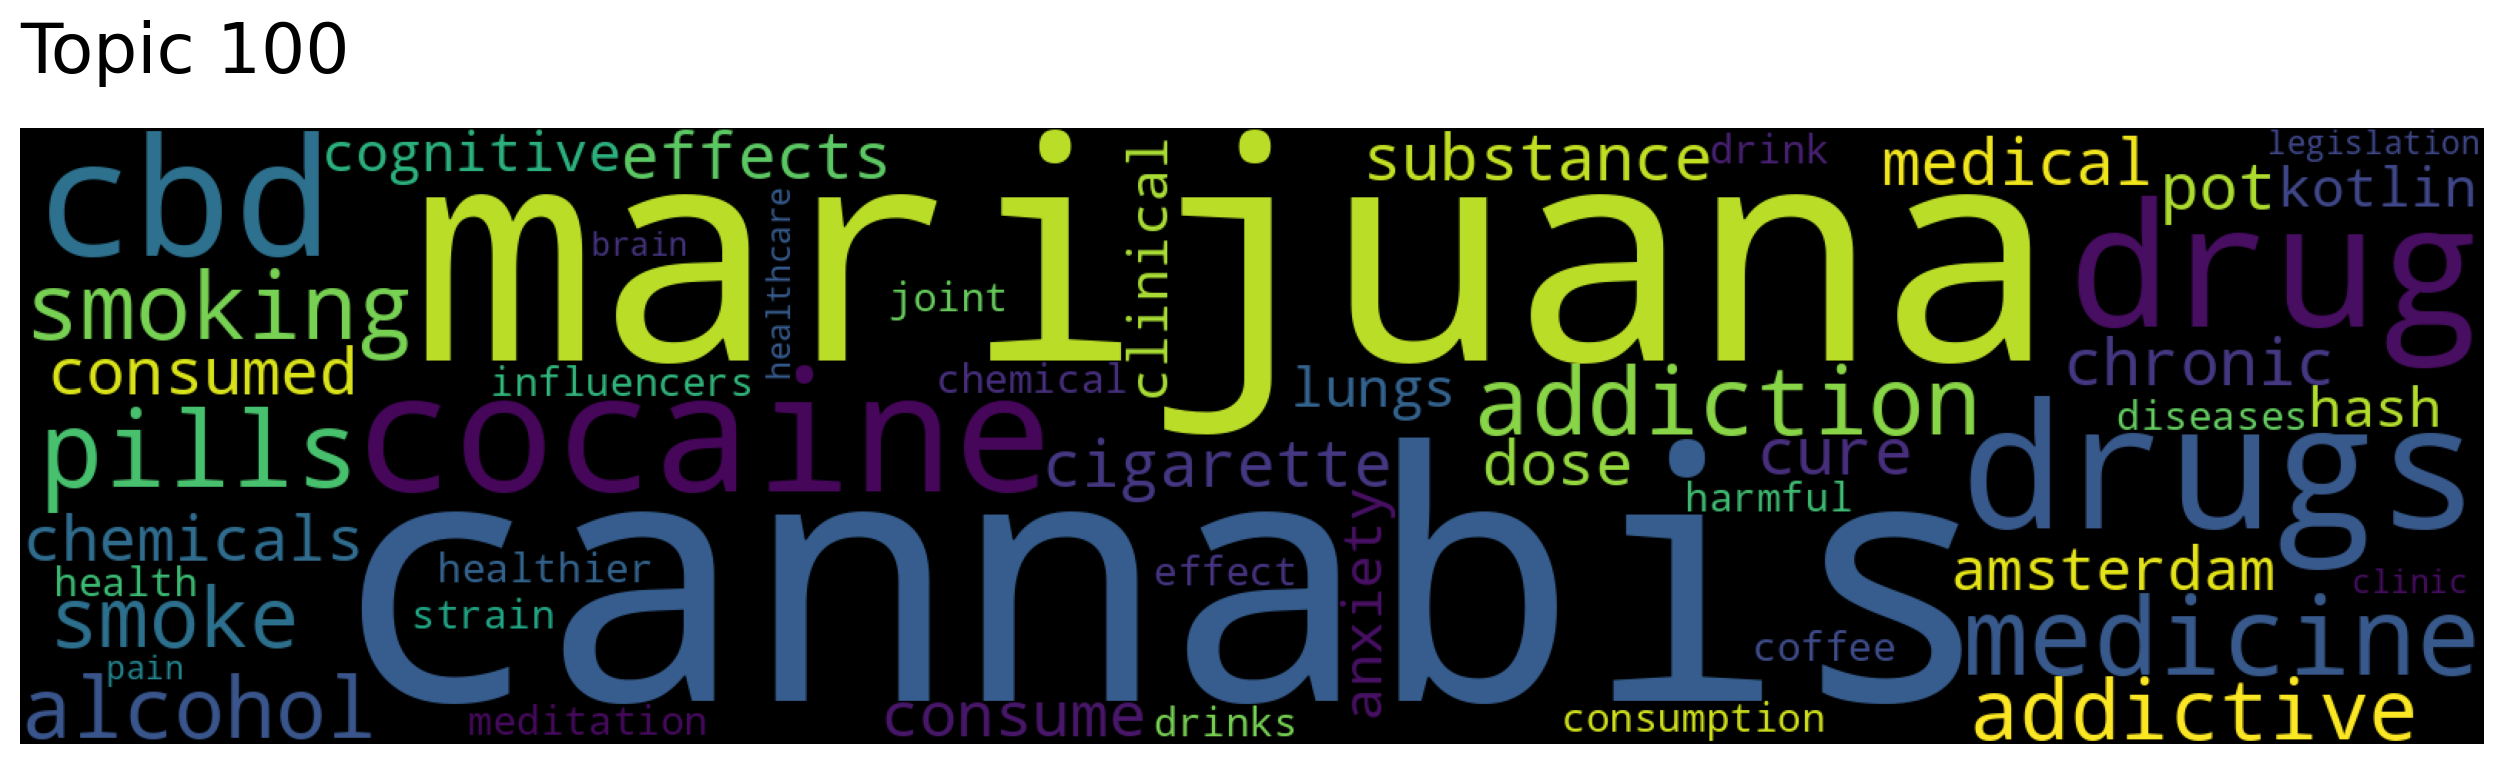

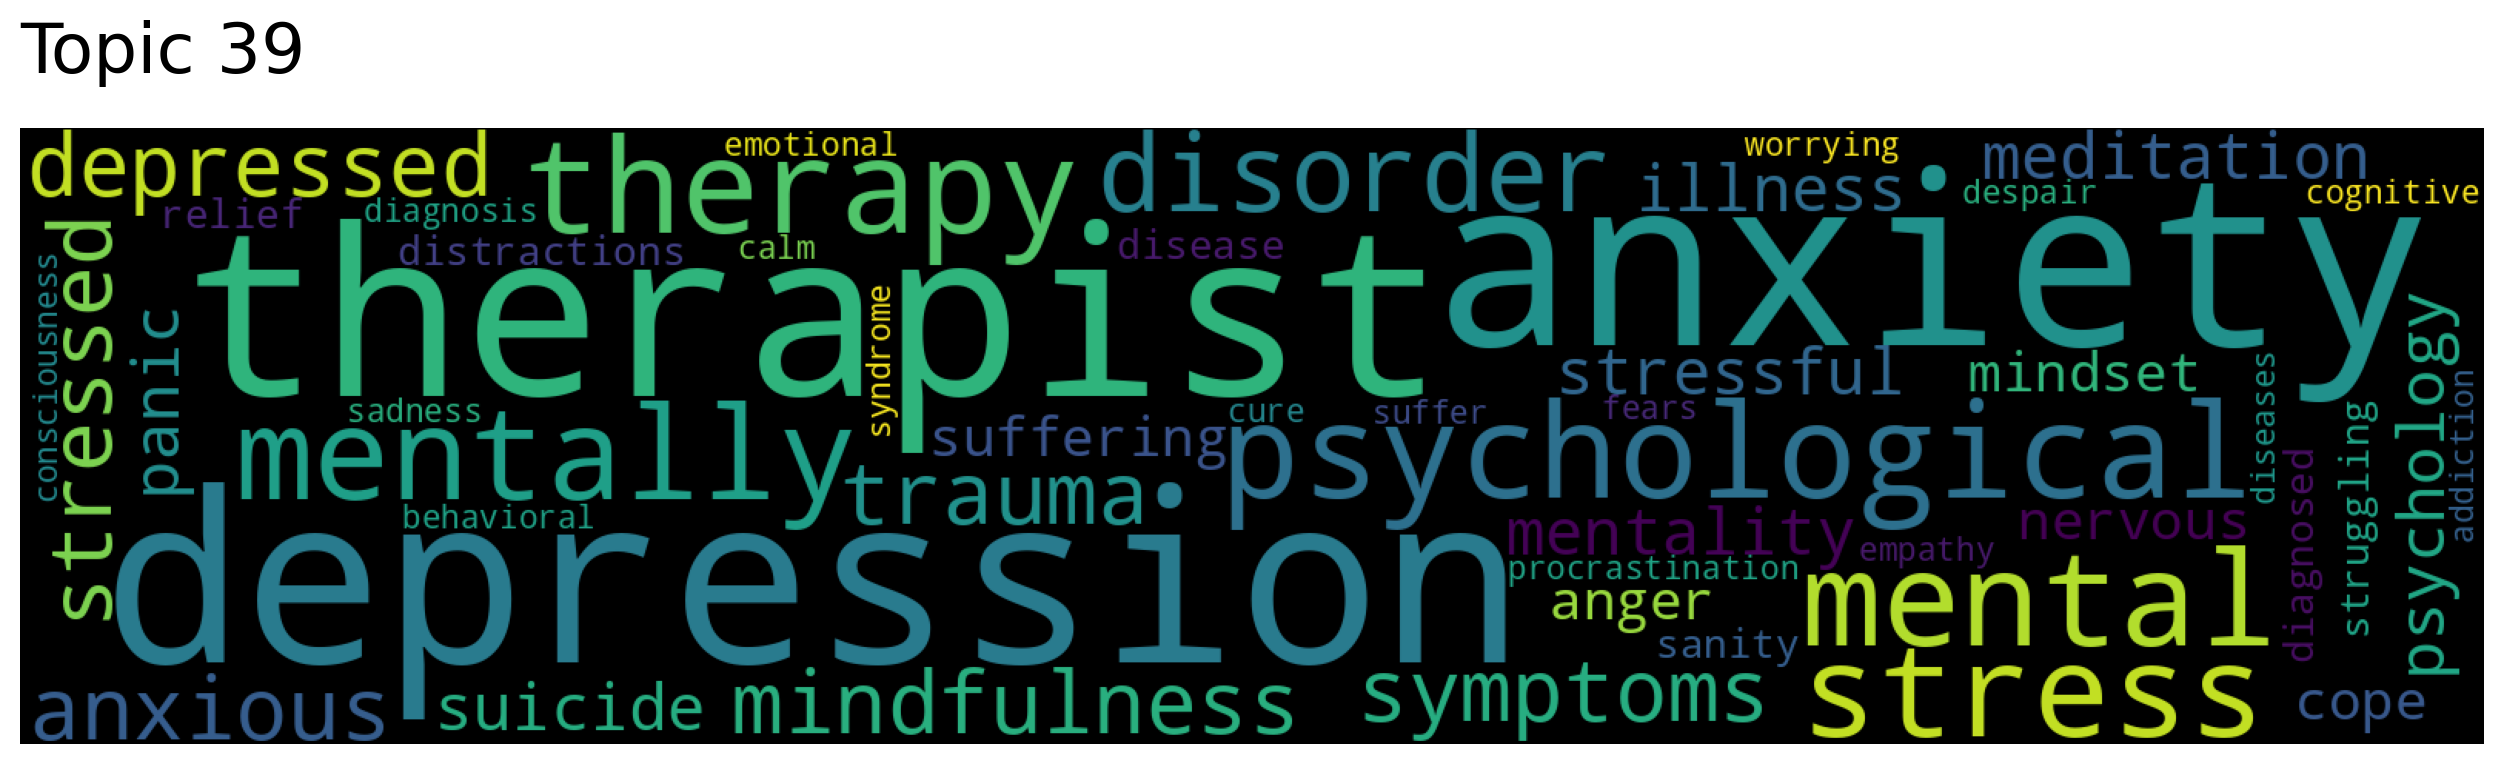

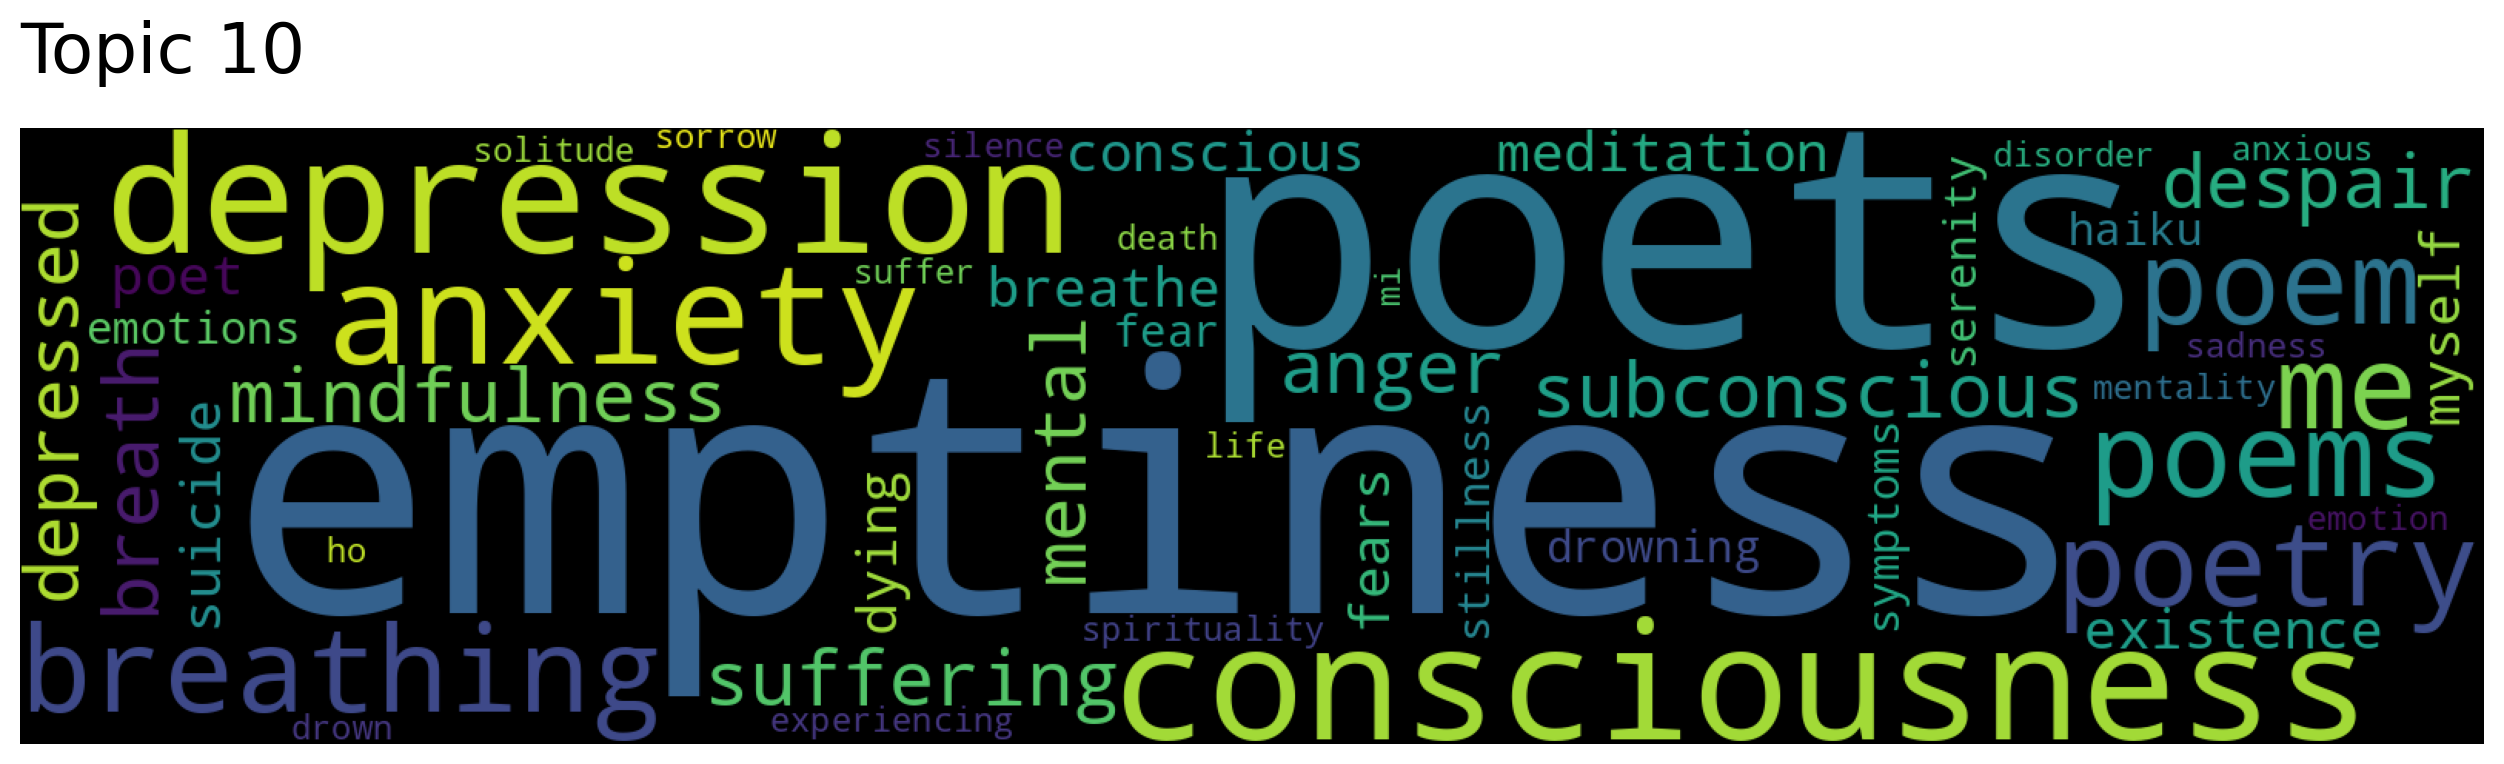

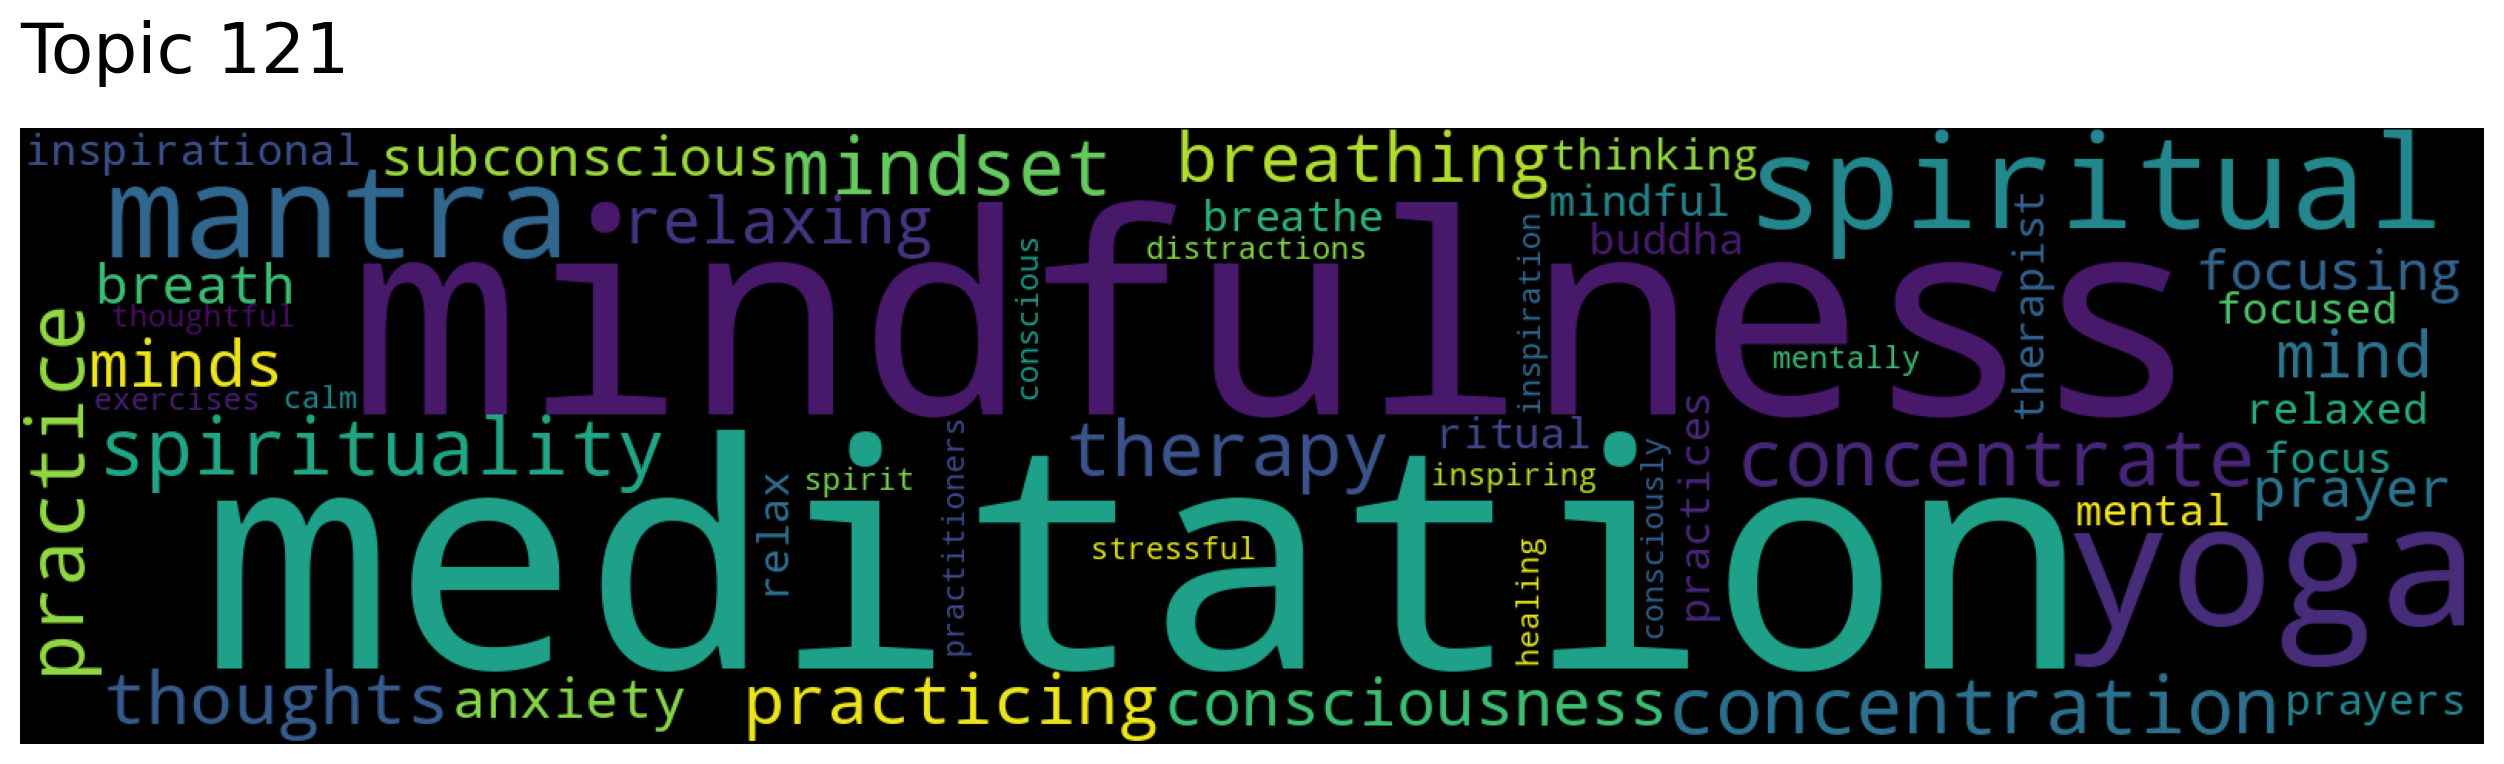

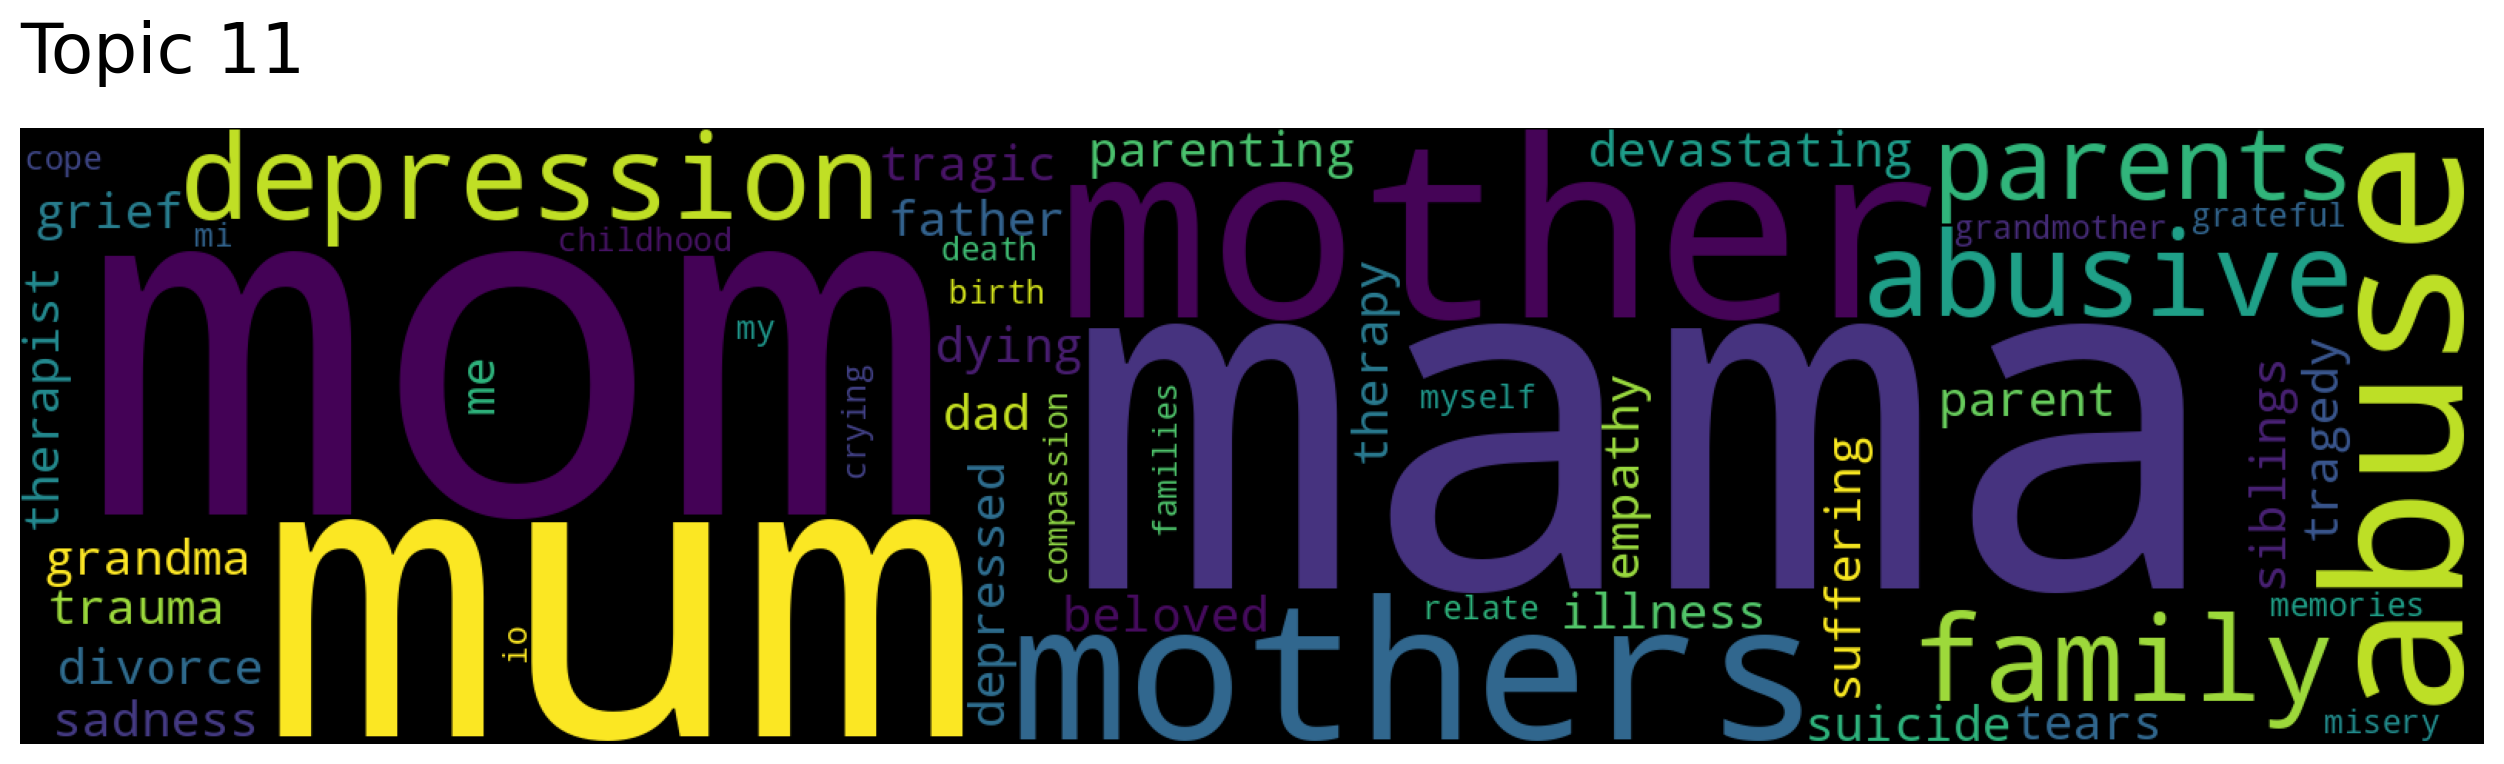

In [44]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["drugs"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

###Reducing the Number of Topics

In [49]:
topic_mapping = model.hierarchical_topic_reduction(num_topics=20)

In [50]:
topic_mapping[1]

[1]

In [53]:
model.topic_words_reduced[3]

array(['nodejs', 'javascript', 'github', 'xcode', 'postgresql',
       'tensorflow', 'firebase', 'dataset', 'functionality', 'dataframe',
       'mysql', 'sql', 'datasets', 'frameworks', 'matplotlib', 'compile',
       'functionalities', 'function', 'databases', 'iterate', 'java',
       'swiftui', 'functions', 'arrays', 'implementation', 'interfaces',
       'npm', 'array', 'plugin', 'css', 'functional', 'callback',
       'wordpress', 'laravel', 'html', 'plugins', 'integration',
       'database', 'backend', 'syntax', 'algorithms', 'framework',
       'implementing', 'struct', 'methodology', 'queries', 'php',
       'feature', 'scala', 'features'], dtype='<U15')

##Overall Summary

The observation highlights that, compared to LDA, both BERTopic and Top2Vec produced superior clusters and word distributions. However, BERTopic exhibited a substantial number of outliers (approximately 13,799), indicating topics that were not clustered effectively. On the other hand, Top2Vec yielded promising results, suggesting that with further fine-tuning, it holds the potential to deliver even better outcomes